In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

#Just to make the variation in params more extreme
bpar['mu_beta'] = 1

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Download files

These are files from the [ULAGAM simulations](https://ulagam-simulations.readthedocs.io/) hosted on gdrive specifically for this example notebook

In [3]:
!rm shell.fits.fz halos.npy

!wget -O shell.fits.fz "https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6"
!wget -O halos.npy     "https://drive.google.com/uc?export=download&id=1JhtFwOzfHG5YWXUDYP1HFfAkq6v5YHKm"

--2025-05-16 23:45:22--  https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6
Resolving drive.google.com (drive.google.com)... 172.217.4.78, 2607:f8b0:4009:805::200e
Connecting to drive.google.com (drive.google.com)|172.217.4.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download [following]
--2025-05-16 23:45:22--  https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.4.193, 2607:f8b0:4009:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.4.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5705280 (5.4M) [application/octet-stream]
Saving to: ‘shell.fits.fz’

shell.fits.fz       100%[===================>]   5.44M  5.51MB/s    in 1.0s    


## Load shell and catalog

In [4]:
min_z = 0.2129219
max_z = 0.2395602

halos = np.load('halos.npy')


#Compute thickness of the shell for projection scale
shell_thickness = ccl.comoving_radial_distance(cosmo, 1/(max_z + 1)) - ccl.comoving_radial_distance(cosmo, 1/(min_z + 1))
bpar['proj_cutoff'] = shell_thickness/2

print(f"SHELL IS {shell_thickness} MPC")


#This is set in units of halo R200c radius.
#You want this to be larger than the radius where you displacement
#function asymptotes to 0
bpar['epsilon_max'] = 10

SHELL IS 103.99377732916025 MPC


## Now setup the models

In [5]:
#Generate a series of 5 models, varying a parameter (M_c)

M_c_vals = [1e12, 1e13, 1e14, 1e15, 1e16]
Model    = []
for M_c in M_c_vals:
    
    bpar['M_c'] = M_c
    
    #Get the pressure profile
    Gas = bfg.Profiles.Gas(**bpar)
    DMB = bfg.Profiles.DarkMatterBaryon(**bpar, twohalo = bfg.Profiles.misc.Zeros()) #No two-halo term in hydrostatic equation
    PRS = bfg.Profiles.Pressure(gas = Gas, darkmatterbaryon = DMB)
    PRS = bfg.Profiles.ThermalSZ(PRS) #Converts Pressure from cgs to compton-y (dimensionless) units
    PRS = bfg.Profiles.misc.ComovingToPhysical(PRS, factor = -3) #Convert to physical units correctly before painting
    
    #Now add the HealPix pixel (a redshift-dependent kernel)
    Pix = bfg.utils.HealPixel(NSIDE = 1024)
    PRS = bfg.utils.ConvolvedProfile(PRS, Pix)
    
    #Now tabulate it (this does both 3D and 2D tabulation)
    PRS = bfg.utils.TabulatedProfile(PRS, cosmo)
    PRS.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                           R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)
    
    Model.append(PRS)

Building Table:   0%|                                                                             | 0/2 [00:00<?, ?it/s]/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:284: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
Building Table: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:263: RuntimeWarning: divide by zero encountered in log
  self.interp3D = interpolate.RegularGridInterpolator(input_grid_1, np.log(interp3D), bounds_error = False)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:264: RuntimeWarning: invalid value encountered in log
  self.interp2D = interpolate.RegularGridInte

## Now setup the runners

In [6]:
#Each model gets its own runner
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}
halos   = bfg.utils.HaloLightConeCatalog(halos['ra'], halos['dec'], halos['M'], halos['z'], cosmo = cdict)

#Just need an empty shell to paint into, so feed it an empty map at the NSIDE you want
shell   = bfg.utils.LightconeShell(np.zeros(hp.nside2npix(1024)), cosmo = cdict)
Runners = []

for M in Model:
    
    #Think carefully about whether you want your map to include the pixel-size during painting. 
    #Setting include_pixel_size = True includes the pixel size in a redshift-dependent way
    #by accounting for the physical pixel size at each redshift.
    
    #For example, if you're passing density profiles but want mass, then you would set this to true.
    Runners.append(
        bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], 
                                       model = M, verbose = True, include_pixel_size = False)
    )

## Now run it!

In [7]:
#You can run it in serial

painted_shell = Runners[0].process()

Painting Profile: 100%|█████████████████████████████████████████████████████████| 18512/18512 [00:06<00:00, 2911.54it/s]


In [8]:
#You can also run individual models in parallel,
#since we can paint over individual halos and accumulate
#at the end. So we split halos into batches, and each process
#works with just one of the batches. The maps are summed in the end
#to get contributions from all halos.

#I set it to 1 here though since my laptop struggles with parallel computing :P
Parallel_Runner = bfg.utils.SplitJoinParallel(Runners[0], njobs = 1)
painted_shell   = Parallel_Runner.process()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.9s


In [9]:
# You can run across the 5 models in parallel as well! :)
# I set njobs to 1 just to have this run on my (aging :P) laptop

Parallel_Runner = bfg.utils.SimpleParallel(Runners, njobs = 1)
painted_shells  = Parallel_Runner.process()

Painting Profile: 100%|█████████████████████████████████████████████████████████| 18512/18512 [00:07<00:00, 2605.50it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    7.8s
Painting Profile: 100%|█████████████████████████████████████████████████████████| 18512/18512 [00:11<00:00, 1637.85it/s]
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   35.0s
Painting Profile: 100%|█████████████████████████████████████████████████████████| 18512/18512 [00:07<00:00, 2445.54it/s]


## Plot the Cls

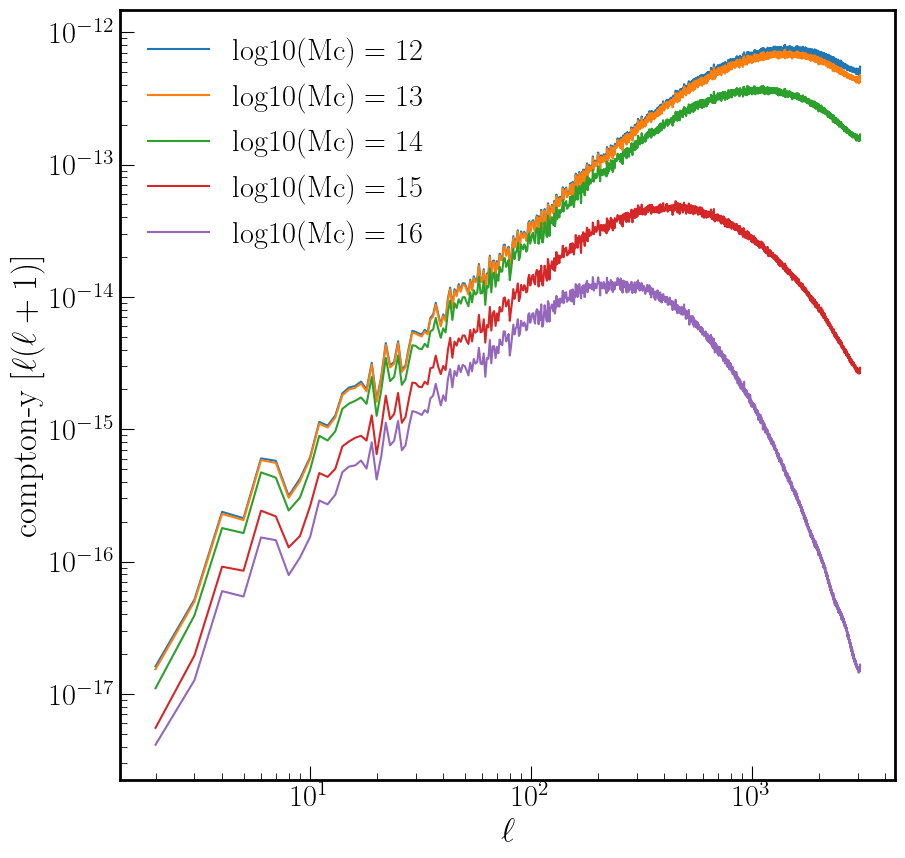

In [10]:
for s, M in zip(painted_shells, M_c_vals):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    ell      = np.arange(modified.size)
    
    #Plot Cls. Dont show monopole and dipole modes
    plt.plot(ell[2:], (ell * (ell + 1) * modified)[2:], label = f'log10(Mc) = {int(np.log10(M))}')

plt.legend(frameon = False)
plt.xlabel(r'$\ell$', size = 25)
plt.ylabel(r'compton-y [$\ell (\ell + 1)$]', size = 25)
plt.xscale('log'); plt.yscale('log');